In [1]:
import numpy as np
np.random.seed(11)
import tensorflow as tf
tf.random.set_seed(11)

2023-02-15 08:26:41.332233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hanh/anaconda3/envs/flowers/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import keras.layers as layers
from keras.models import Sequential
from keras.utils import np_utils, load_img, img_to_array

In [3]:
from sklearn.datasets import load_files
from tqdm import tqdm
import pandas as pd
import os

## Load images

In [4]:
def load_dataset(path):
    files = load_files(path)
    targets_int = np.array([int(f.split(os.sep)[4]) for f in files.filenames]) # extract the flower category
    targets_int -= 1
    targets_cat = np_utils.to_categorical(targets_int, 102)
    return files.filenames, targets_int, targets_cat

# load train, test, and validation datasets
train_files, train_targets_int, train_targets = load_dataset('./Data/Datasplit/train')
valid_files, valid_targets_int, valid_targets = load_dataset('./Data/Datasplit/valid')
test_files, test_targets_int, test_targets = load_dataset('./Data/Datasplit/test')

## Pre-process the Data

In [5]:
def path_to_tensor(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████| 6149/6149 [00:26<00:00, 235.42it/s]


## Build a CNN model from scratch
- All kernel sizes at the three convolutional blocks were 3 x 3 to provide fine-detailed features at multiple scales

In [7]:
cnn = Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same', input_shape=[224, 224, 3]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),
    
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=102, activation="softmax"),
])

cnn.summary()

2023-02-15 08:27:29.091600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 08:27:29.112500: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 dropout (Dropout)           (None, 224, 224, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0

In [8]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=True)

history = cnn.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

In [9]:
cnn.evaluate(train_tensors, train_targets)
cnn.evaluate(valid_tensors, valid_targets)
cnn.evaluate(test_tensors, test_targets);

193/193 [==============================] - 47s 244ms/step - loss: 14.4981 - accuracy: 0.1407


In [10]:
# get prediction
flower_preds = [np.argmax(cnn.predict(np.expand_dims(tensor, axis=0), verbose=0)) for tensor in test_tensors]

In [11]:
# another way to get accuracy
test_accuracy = 100*np.sum(np.array(flower_preds)==np.argmax(test_targets, axis=1))/len(flower_preds)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 14.07%


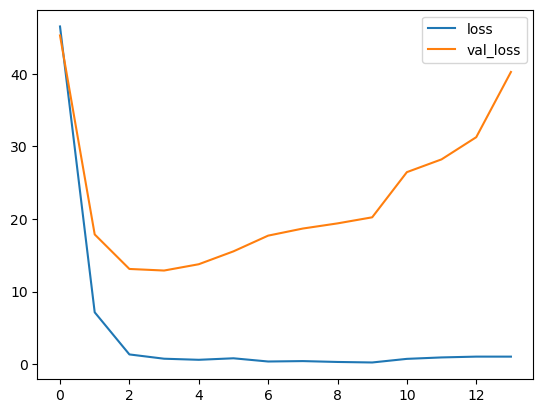

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

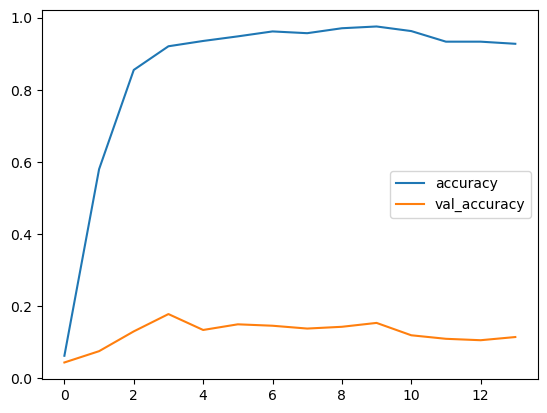

In [13]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();